# GR00T Inference

This tutorial shows how to use the GR00T inference model to predict the actions from the observations, given a test dataset.

In [1]:
import os
import torch
import gr00t

from gr00t.data.dataset.lerobot_episode_loader import LeRobotEpisodeLoader
from gr00t.data.dataset.sharded_single_step_dataset import extract_step_data
from gr00t.data.embodiment_tags import EmbodimentTag
from gr00t.policy.gr00t_policy import Gr00tPolicy

/workspace/gr00t/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# change the following paths
MODEL_PATH = "nvidia/GR00T-N1.6-3B"

# REPO_PATH is the path of the pip install gr00t repo and one level up
REPO_PATH = os.path.dirname(os.path.dirname(gr00t.__file__))
DATASET_PATH = os.path.join(REPO_PATH, "demo_data/gr1.PickNPlace")
EMBODIMENT_TAG = "gr1"

device = "cuda" if torch.cuda.is_available() else "cpu"

## Loading Pretrained Policy

Policy Model is loaded just like any other huggingface model.

There are 2 new concepts here in the GR00T model:
 - modality config: This defines the keys in the dictionary used by the model. (e.g. `action`, `state`, `annotation`, `video`)
 - modality_transform: A sequence of transform which are used during dataloading

In [ ]:
policy = Gr00tPolicy(
    model_path=MODEL_PATH,
    embodiment_tag=EmbodimentTag(EMBODIMENT_TAG),
    device=device,
    strict=True,
)

# print out the policy model architecture
print(policy.model)

## Loading dataset

First this requires user to check which embodiment tags are used to pretrained the `Gr00tPolicy` pretrained models.

In [4]:
import numpy as np

modality_config = policy.get_modality_config()

print(modality_config.keys())

for key, value in modality_config.items():
    if isinstance(value, np.ndarray):
        print(key, value.shape)
    else:
        print(key, value)


dict_keys(['video', 'state', 'action', 'language'])
video ModalityConfig(delta_indices=[0], modality_keys=['ego_view_bg_crop_pad_res256_freq20'], sin_cos_embedding_keys=None, mean_std_embedding_keys=None, action_configs=None)
state ModalityConfig(delta_indices=[0], modality_keys=['left_arm', 'right_arm', 'left_hand', 'right_hand', 'waist'], sin_cos_embedding_keys=['left_arm', 'right_arm', 'left_hand', 'right_hand', 'waist'], mean_std_embedding_keys=None, action_configs=None)
action ModalityConfig(delta_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], modality_keys=['left_arm', 'right_arm', 'left_hand', 'right_hand', 'waist'], sin_cos_embedding_keys=None, mean_std_embedding_keys=None, action_configs=[ActionConfig(rep=<ActionRepresentation.RELATIVE: 'relative'>, type=<ActionType.NON_EEF: 'non_eef'>, format=<ActionFormat.DEFAULT: 'default'>, state_key=None), ActionConfig(rep=<ActionRepresentation.RELATIVE: 'relative'>, type=<ActionType.NON_EEF: 'non_eef'>, format=<ActionFor

In [5]:
# Create the dataset
dataset = LeRobotEpisodeLoader(
    dataset_path=DATASET_PATH,
    modality_configs=modality_config,
    video_backend="torchcodec",
    video_backend_kwargs=None,
)

Let's print out a single data and visualize it

In [6]:
import numpy as np

episode_data = dataset[0]
step_data = extract_step_data(
    episode_data, step_index=0, modality_configs=modality_config, embodiment_tag=EmbodimentTag(EMBODIMENT_TAG), allow_padding=False
)

# print(step_data)

print("\n\n====================================")
print("Images:")
for img_key in step_data.images:
    print(" " * 4, img_key, f"{len(step_data.images[img_key])} x {step_data.images[img_key][0].shape}")

print("\nStates:")
for state_key in step_data.states:
    print(" " * 4, state_key, step_data.states[state_key].shape)

print("\nActions:")
for action_key in step_data.actions:
    print(" " * 4, action_key, step_data.actions[action_key].shape)

print("\nTask: ", step_data.text)




Images:
     ego_view_bg_crop_pad_res256_freq20 1 x (256, 256, 3)

States:
     left_arm (1, 7)
     right_arm (1, 7)
     left_hand (1, 6)
     right_hand (1, 6)
     waist (1, 3)

Actions:
     left_arm (16, 7)
     right_arm (16, 7)
     left_hand (16, 6)
     right_hand (16, 6)
     waist (16, 3)

Task:  pick the pear from the counter and place it in the plate


Let's plot just the "right arm" state and action data and see how it looks like. Also show the images of the right hand state.

416


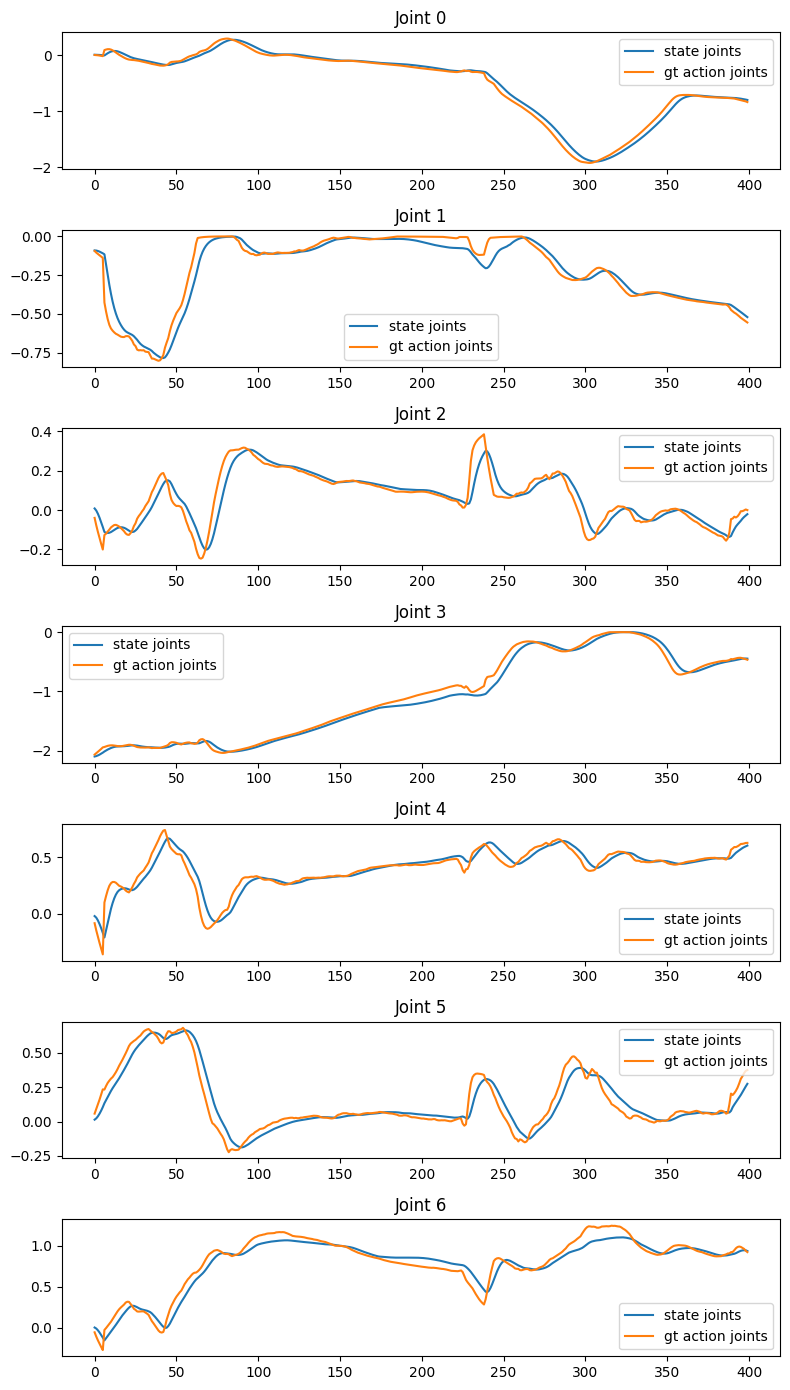

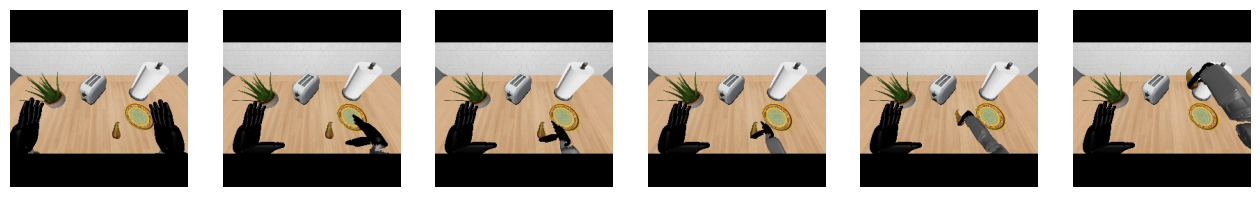

In [7]:
import matplotlib.pyplot as plt

episode_index = 0
max_steps = 400
joint_name = "right_arm"
image_key = "ego_view_bg_crop_pad_res256_freq20"

state_joints_across_time = []
gt_action_joints_across_time = []
images = []

sample_images = 6
episode_data = dataset[episode_index]
print(len(episode_data))

for step_count in range(max_steps):
    data_point = extract_step_data(
        episode_data, step_index=step_count, modality_configs=modality_config, embodiment_tag=EmbodimentTag(EMBODIMENT_TAG), allow_padding=False
    )
    state_joints = data_point.states[joint_name][0]
    gt_action_joints = data_point.actions[joint_name][0]

    state_joints_across_time.append(state_joints)
    gt_action_joints_across_time.append(gt_action_joints)

    # We can also get the image data
    if step_count % (max_steps // sample_images) == 0:
        image = data_point.images[image_key][0]
        images.append(image)

# Size is (max_steps, num_joints)
state_joints_across_time = np.array(state_joints_across_time)
gt_action_joints_across_time = np.array(gt_action_joints_across_time)


# Plot the joint angles across time
num_joints = state_joints_across_time.shape[1]
fig, axes = plt.subplots(nrows=num_joints, ncols=1, figsize=(8, 2*num_joints))

for i, ax in enumerate(axes):
    ax.plot(state_joints_across_time[:, i], label="state joints")
    ax.plot(gt_action_joints_across_time[:, i], label="gt action joints")
    ax.set_title(f"Joint {i}")
    ax.legend()

plt.tight_layout()
plt.show()


# Plot the images in a row
fig, axes = plt.subplots(nrows=1, ncols=sample_images, figsize=(16, 4))

for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.axis("off")

Now we can run the policy from the pretrained checkpoint.

In [8]:
observation = {
    "video": {k: np.stack(step_data.images[k])[None] for k in step_data.images},  # stach images and add batch dimension
    "state": {k: step_data.states[k][None] for k in step_data.states},  # add batch dimension
    "action": {k: step_data.actions[k][None] for k in step_data.actions},  # add batch dimension
    "language": {
        modality_config["language"].modality_keys[0]: [[step_data.text]],  # add time and batch dimension
    }
}
predicted_action, info = policy.get_action(observation)
for key, value in predicted_action.items():
    print(key, value.shape)

left_arm (1, 16, 7)
right_arm (1, 16, 7)
left_hand (1, 16, 6)
right_hand (1, 16, 6)
waist (1, 16, 3)


For more details on the policy (e.g. expected input and output), please refer to the [policy documentation](policy.md).

In [2]:
import datasets

In [3]:
print(datasets.__version__)

4.0.0


In [4]:
dataset = datasets.load_dataset(
    path="LSY-lab/stack_without_ft_tact_v4",
    split="train[:1]",  # grab just the first episode for a quick preview
    streaming=False,
)

Generating train split: 100%|██████████| 12244/12244 [00:00<00:00, 175879.51 examples/s]


In [16]:
dataset.features

{'observation.state.cartesian': List(Value('float32'), length=6),
 'observation.state.gripper': Value('float32'),
 'observation.state.joints': List(Value('float32'), length=7),
 'observation.state.target': List(Value('float32'), length=6),
 'observation.state': List(Value('float32'), length=20),
 'action': List(Value('float32'), length=7),
 'timestamp': Value('float32'),
 'frame_index': Value('int64'),
 'episode_index': Value('int64'),
 'index': Value('int64'),
 'task_index': Value('int64')}

In [17]:
#display a sample from the dataset
dataset

Dataset({
    features: ['observation.state.cartesian', 'observation.state.gripper', 'observation.state.joints', 'observation.state.target', 'observation.state', 'action', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index'],
    num_rows: 1
})

In [1]:
# Find the first video file in the HF dataset repo and display it
from pathlib import Path
from IPython.display import Video
from huggingface_hub import hf_hub_download, list_repo_files

repo_id = "LSY-lab/stack_without_ft_tact_v4"

mp4_files = [f for f in list_repo_files(repo_id, repo_type="dataset") if f.lower().endswith(".mp4")]
if not mp4_files:
    raise ValueError("No .mp4 files found in the dataset repository")

video_filename = mp4_files[1]
video_path = hf_hub_download(
    repo_id=repo_id,
    filename=video_filename,
    repo_type="dataset",
)

print(f"Using video file: {video_filename}")
print(f"Cached file: {video_path}")

if not Path(video_path).exists():
    raise FileNotFoundError(f"Downloaded video not found at {video_path}")

Video(video_path, embed=True, width=480)

/workspace/gr00t/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using video file: videos/chunk-000/observation.images.primary/episode_000001.mp4
Cached file: /root/.cache/huggingface/hub/datasets--LSY-lab--stack_without_ft_tact_v4/snapshots/10f54171c5b08c68bd4af114e4c9a8661ca291d2/videos/chunk-000/observation.images.primary/episode_000001.mp4


In [2]:
!pip install lerobot --no-deps

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.14.3-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.27a0+5111d3b-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. p

In [1]:
import lerobot